# Plate supported at the corners

In [1]:
from skfem import *
from skfem.visuals.matplotlib import *
%matplotlib inline
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

In [2]:
def problem(m):

    e = ElementTriArgyris()
    e.derivatives = 4
    t = 1.
    E = 1.
    nu = 0.3
    D = E * t ** 3 / (12. * (1. - nu ** 2))

    def C(T):
        trT = T[0, 0] + T[1, 1]
        return E / (1. + nu) * \
            np.array([[T[0, 0] + nu / (1. - nu) * trT, T[0, 1]],
                      [T[1, 0], T[1, 1] + nu / (1. - nu) * trT]])

    def K(ddu):
        return -ddu

    def M(ddu):
        return t ** 3 / 12. * C(-ddu)

    def divM(T): # input K
        trT1 = T[0, 0, 0] + T[1, 1, 0]
        trT2 = T[0, 0, 1] + T[1, 1, 1]
        return t ** 3 / 12 * E / (1. + nu) * \
            np.array([T[0, 0, 0] + nu / (1. - nu) * trT1 + T[0, 1, 1],
                      T[1, 0, 0] + T[1, 1, 1] + nu / (1. - nu) * trT2])

    def gradM(T): # input K
        trT1 = T[0, 0, 0] + T[1, 1, 0]
        trT2 = T[0, 0, 1] + T[1, 1, 1]
        return t ** 3 / 12 * E / (1. + nu) * \
            np.array([[[T[0, 0, 0] + nu / (1. - nu) * trT1, T[0, 0, 1] + nu / (1. - nu) * trT2],
                       [T[0, 1, 0], T[0, 1, 1]]],
                      [[T[1, 0, 0], T[1, 0, 1]],
                       [T[1, 1, 0] + nu / (1. - nu) * trT1, T[1, 1, 1] + nu / (1. - nu) * trT2]]])

    def Vn(dddu, n):
        from skfem.helpers import dot, ddot, dddot, prod
        s = n.copy()
        s[0] = -n[1]
        s[1] = n[0]
        return dot(divM(-dddu), n) + dddot(gradM(-dddu), prod(n, s, s))

    def Mnn(ddu, n):
        from skfem.helpers import ddot, prod
        return ddot(M(ddu), prod(n, n))

    def Mns(ddu, n):
        from skfem.helpers import ddot, prod
        s = n.copy()
        s[0] = -n[1]
        s[1] = n[0]
        return ddot(M(ddu), prod(n, s))

    @BilinearForm
    def bilinf(u, v, w):
        from skfem.helpers import ddot, dd
        return ddot(M(dd(u)), K(dd(v)))

    def F(x, y):
        return 1. + 0. * x

    @LinearForm
    def linf(v, w):
        return F(*w.x) * v

    gamma1 = 1e-3
    gamma2 = gamma1
    gamma3 = gamma1

    @BilinearForm
    def penalty_1(u, v, w):
        from skfem.helpers import d, ddd, dot
        return 1. / (gamma1 * w.h ** 3) * u * v\
               + Vn(ddd(u), w.n) * v + u * Vn(ddd(v), w.n)

    @BilinearForm
    def penalty_2(u, v, w):
        from skfem.helpers import d, dd, dot
        return 1. / (gamma2 * w.h) * dot(d(u), w.n) * dot(d(v), w.n)\
               - dot(d(u), w.n) * Mnn(dd(v), w.n) - Mnn(dd(u), w.n) * dot(d(v), w.n)

    @BilinearForm
    def penalty_3h(u, v, w):
        from skfem.helpers import d, dd, dot
        return (1. / (gamma3 * w.h ** 2) * u * v + Mns(dd(u), w.n) * v + Mns(dd(v), w.n) * u) / w.h \
            * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)

    @BilinearForm
    def penalty_3v(u, v, w):
        from skfem.helpers import d, dd, dot
        return (Mns(dd(u), w.n) * v + Mns(dd(v), w.n) * u) / w.h \
            * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)

    basis = InteriorBasis(m, e)
    fbasis = FacetBasis(m, e)
    cbasis_h = FacetBasis(m, e,
                          facets=m.facets_satisfying(lambda x: np.abs(x[1] - 0.5) == 0.5),
                          quadrature=(np.array([[0.0, 1.0]]),
                                      np.array([1.0, 1.0])))
    cbasis_v = FacetBasis(m, e,
                          facets=m.facets_satisfying(lambda x: np.abs(x[0] - 0.5) == 0.5),
                          quadrature=(np.array([[0.0, 1.0]]),
                                      np.array([1.0, 1.0])))

    A = asm(bilinf, basis)
    B1 = asm(penalty_1, fbasis)
    B2 = asm(penalty_2, fbasis)
    B3 = asm(penalty_3h, cbasis_h)
    B4 = asm(penalty_3v, cbasis_v)
    b = asm(linf, basis)

    x = solve(A + B3 + B4, b)
    ax = draw(m, figsize=(6, 6))
    Nrefs = 5
    plot(basis, x, Nrefs=Nrefs, colorbar=True, ax=ax)
    
    # interior error

    @Functional
    def est_interior(w):
        from skfem.helpers import dddd
        u = w['w']
        D4u = dddd(u)
        return w.h ** 4 * (D * (D4u[0, 0, 0, 0]\
                                + 2 * D4u[0, 0, 1, 1]\
                                + D4u[1, 1, 1, 1]) - F(*w.x)) ** 2

    interpx = basis.interpolate(x)

    estimators1 = est_interior.elemental(basis, w=interpx)

    # interior jumps

    @Functional
    def est_Mjump(w):
        from skfem.helpers import dd
        u0, u1 = w['w'], w['w1']
        return w.h * (Mnn(dd(u0), w.n) - Mnn(dd(u1), w.n)) ** 2

    @Functional
    def est_Vjump(w):
        from skfem.helpers import ddd
        u0, u1 = w['w'], w['w1']
        return w.h ** 3 * (Vn(ddd(u0), w.n) - Vn(ddd(u1), w.n)) ** 2

    fb0 = FacetBasis(m, e, side=0)
    fb1 = FacetBasis(m, e, side=1)

    w0 = fb0.interpolate(x)
    w1 = fb1.interpolate(x)

    estimators2 = np.zeros(m.facets.shape[1])
    estimators2[m.interior_facets()] = est_Mjump.elemental(fb0, w=w0, w1=w1)
    estimators2[m.interior_facets()] += est_Vjump.elemental(fb0, w=w0, w1=w1)
    estimators2 = 0.5 * np.sum(estimators2[m.t2f], axis=0)


    # boundary error

    @Functional
    def bnd_error(w):
        from skfem.helpers import ddd, dd
        u = w['w']
        return w.h ** 3 * Vn(ddd(u), w.n) ** 2 + w.h * Mnn(dd(u), w.n)


    estimators3 = np.zeros(m.facets.shape[1])
    estimators3[m.boundary_facets()] = bnd_error.elemental(fbasis, w=fbasis.interpolate(x))
    estimators3 = np.sum(estimators3[m.t2f], axis=0)
    
    # corner estimator
        
    @Functional
    def corner_estimator(w):
        from skfem.helpers import d, dd, dot
        return w['w'] / w.h ** 2 \
            * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)
    
    estimators4 = np.zeros(m.facets.shape[1])
    estimators4[m.boundary_facets()] = corner_estimator.elemental(fbasis, w=fbasis.interpolate(x))
    estimators4 = np.sum(estimators4[m.t2f], axis=0)

    # sum total

    estimators = estimators1 + estimators2 + estimators3 + estimators4

    plot(m, estimators, colorbar=True)
    
    print('{},{}'.format(len(x), np.sqrt(np.sum(estimators))))
    
    return estimators

N,estimators
206,0.048752878155390346
450,0.015072044448378546
694,0.005156477452914225
938,0.002634121713212008
1326,0.0007597478741463569


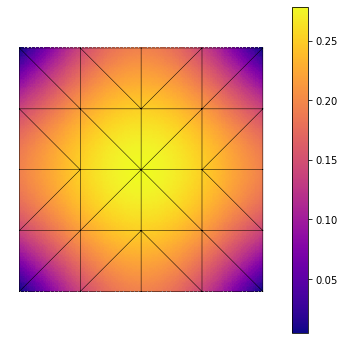

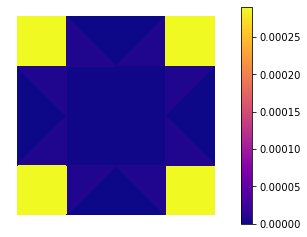

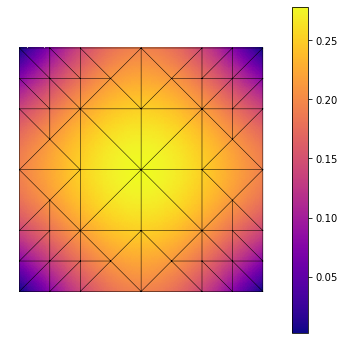

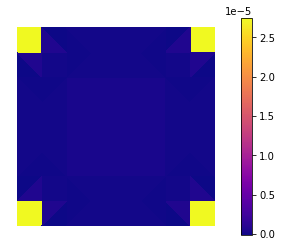

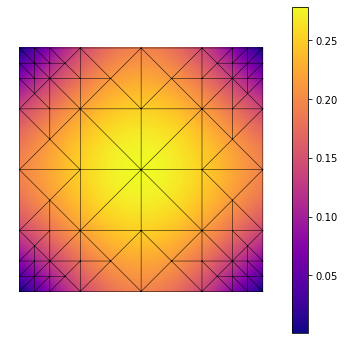

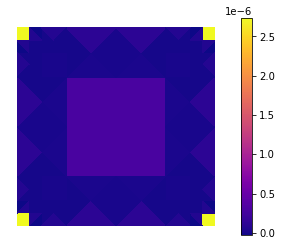

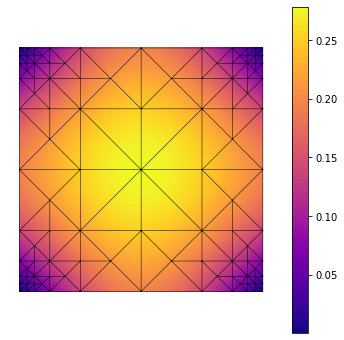

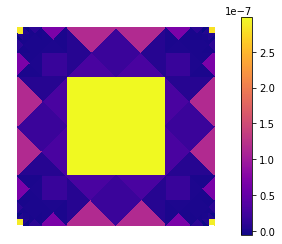

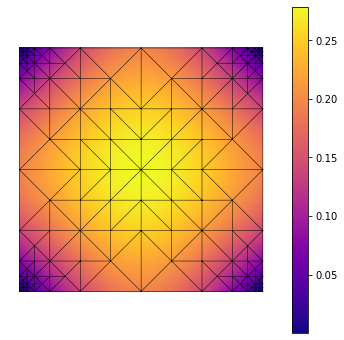

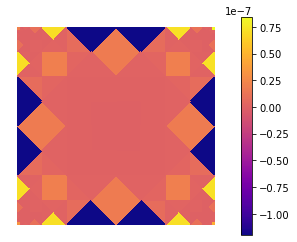

In [3]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m)
    m.refine(adaptive_theta(est))

N,estimators
206,0.048752878155390346
694,0.014927639377125396
2534,0.004676001314030707
9670,0.001502225430439037


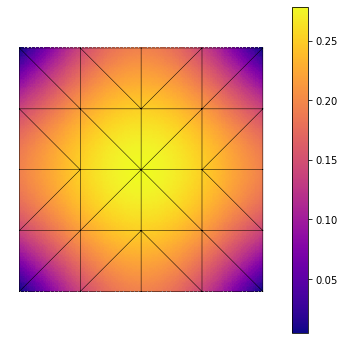

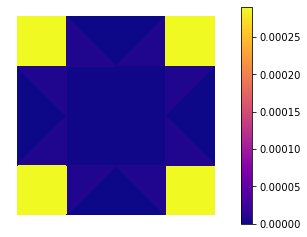

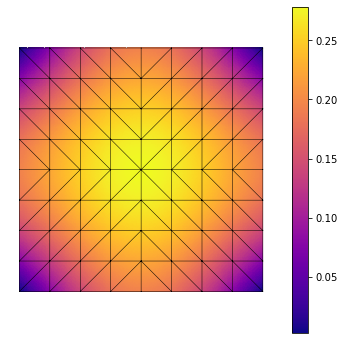

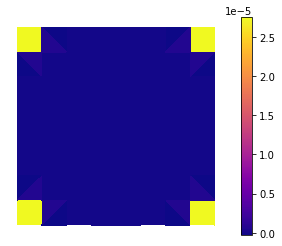

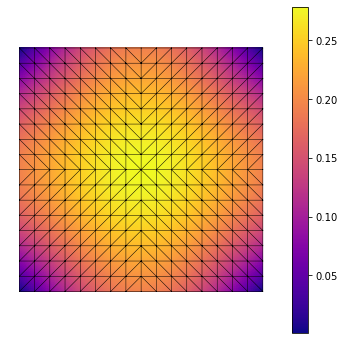

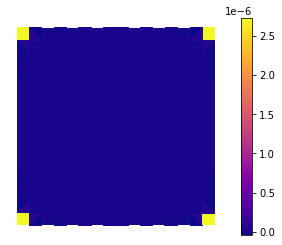

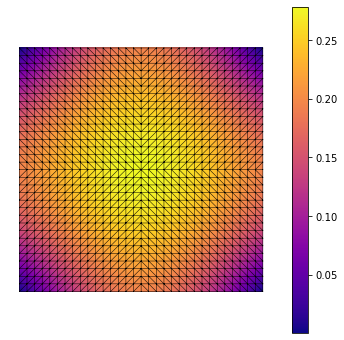

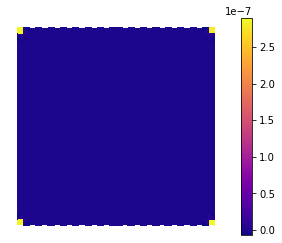

In [4]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(4):
    est = problem(m)
    m.refine()